1. **Load & Preprocess Data**

In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Flatten, Dense, Dropout, 
                                     BatchNormalization, GlobalAveragePooling2D, Input)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import EfficientNetB0
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

2. Exploratory Data Analysis (EDA)


In [3]:
BASE_DIR = "/kaggle/input/melanoma-cancer-dataset/"  # Change this as needed
TRAIN_DIR = os.path.join(BASE_DIR, "train")
TEST_DIR = os.path.join(BASE_DIR, "test")

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

In [4]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)


Found 9504 images belonging to 2 classes.
Found 2375 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


Build CNN Model

In [6]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', patience=2)
]

In [7]:
cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

print("Training CNN model...")
cnn_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15,
    callbacks=callbacks
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training CNN model...
Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


297/297 ━━━━━━━━━━━━━━━━━━━━ 712s 2s/step - accuracy: 0.6684 - loss: 0.6228 - val_accuracy: 0.7575 - val_loss: 0.5180 - learning_rate: 0.0010
Epoch 2/15
297/297 ━━━━━━━━━━━━━━━━━━━━ 684s 2s/step - accuracy: 0.8170 - loss: 0.4205 - val_accuracy: 0.7655 - val_loss: 0.5409 - learning_rate: 0.0010
Epoch 3/15
297/297 ━━━━━━━━━━━━━━━━━━━━ 683s 2s/step - accuracy: 0.8362 - loss: 0.3854 - val_accuracy: 0.7739 - val_loss: 0.5155 - learning_rate: 0.0010
Epoch 4/15
297/297 ━━━━━━━━━━━━━━━━━━━━ 703s 2s/step - accuracy: 0.8336 - loss: 0.3932 - val_accuracy: 0.7684 - val_loss: 0.5312 - learning_rate: 0.0010
Epoch 5/15
297/297 ━━━━━━━━━━━━━━━━━━━━ 684s 2s/step - accuracy: 0.8433 - loss: 0.3737 - val_accuracy: 0.7596 - val_loss: 0.5251 - learning_rate: 0.0010
Epoch 6/15
297/297 ━━━━━━━━━━━━━━━━━━━━ 685s 2s/step - accuracy: 0.8580 - loss: 0.3317 - val_accuracy: 0.7954 - val_loss: 0.4735 - learning_rate: 1.0000e-04
Epoch 7/15
297/297 ━━━━━━━━━━━━━━━━━━━━ 703s 2s/step - accuracy: 0.8545 - loss: 0.3344 - 

63/63 ━━━━━━━━━━━━━━━━━━━━ 37s 588ms/step
Classification Report for CNN:
              precision    recall  f1-score   support

           0       0.84      0.91      0.87      1000
           1       0.90      0.82      0.86      1000

    accuracy                           0.86      2000
   macro avg       0.87      0.86      0.86      2000
weighted avg       0.87      0.86      0.86      2000



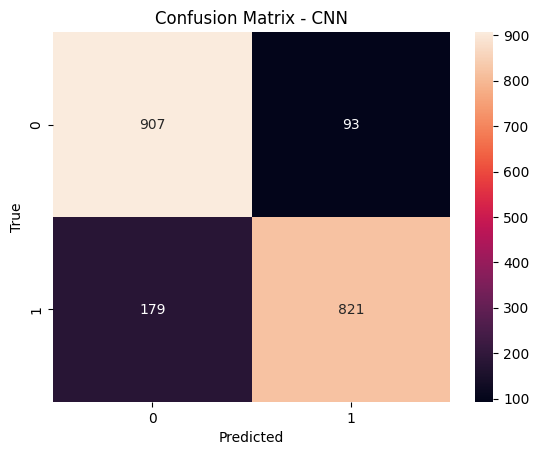

In [10]:
def evaluate_model(model, name="Model"):
    predictions = model.predict(test_generator)
    y_pred = (predictions > 0.5).astype(int)
    y_true = test_generator.classes

    print(f"Classification Report for {name}:")
    print(classification_report(y_true, y_pred))

    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

evaluate_model(cnn_model, "CNN")